In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
%matplotlib inline


In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/DE_Simulation.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

#Define Setting

In [0]:
df_input = df[['ds', 'simulated']]
df_input = df_input.rename(columns = {'simulated' : 'activations'})
df_input['ds'] =  pd.to_datetime(df_input['ds'])
df_input.head()

Out[29]:

,ds,activations
0,2018-01-07 00:00:00+00:00,5471.0
1,2018-01-14 00:00:00+00:00,5228.0
2,2018-01-21 00:00:00+00:00,5489.0
3,2018-01-28 00:00:00+00:00,5114.0
4,2018-02-04 00:00:00+00:00,6961.0


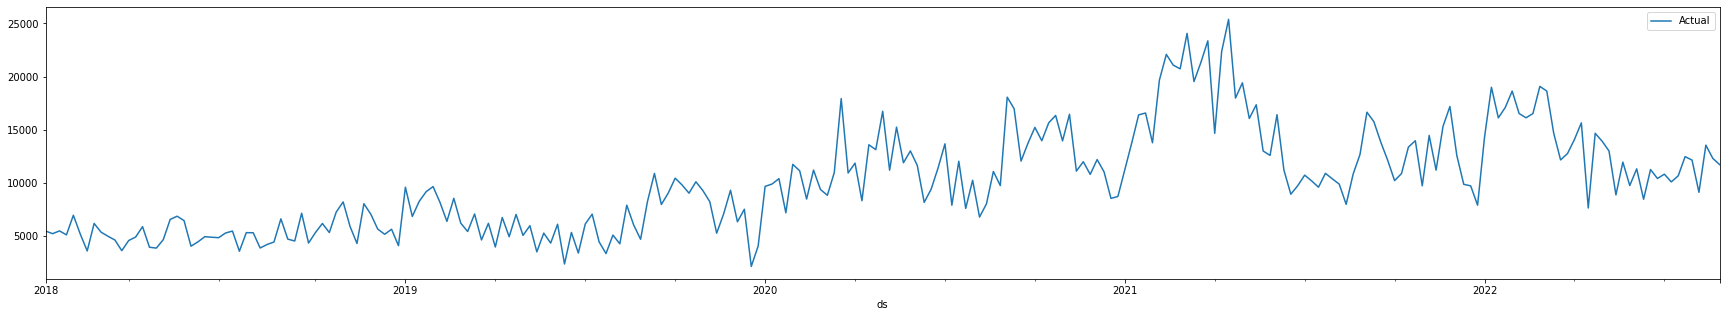

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

df_input.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
plt.legend()
plt.show()

In [0]:
with_covid = df_input[df_input['ds'] >= '2020-01-01']
with_covid.head()

Out[31]:

,ds,activations
104,2020-01-05 00:00:00+00:00,9673.0
105,2020-01-12 00:00:00+00:00,9895.0
106,2020-01-19 00:00:00+00:00,10403.0
107,2020-01-26 00:00:00+00:00,7191.0
108,2020-02-02 00:00:00+00:00,11744.0


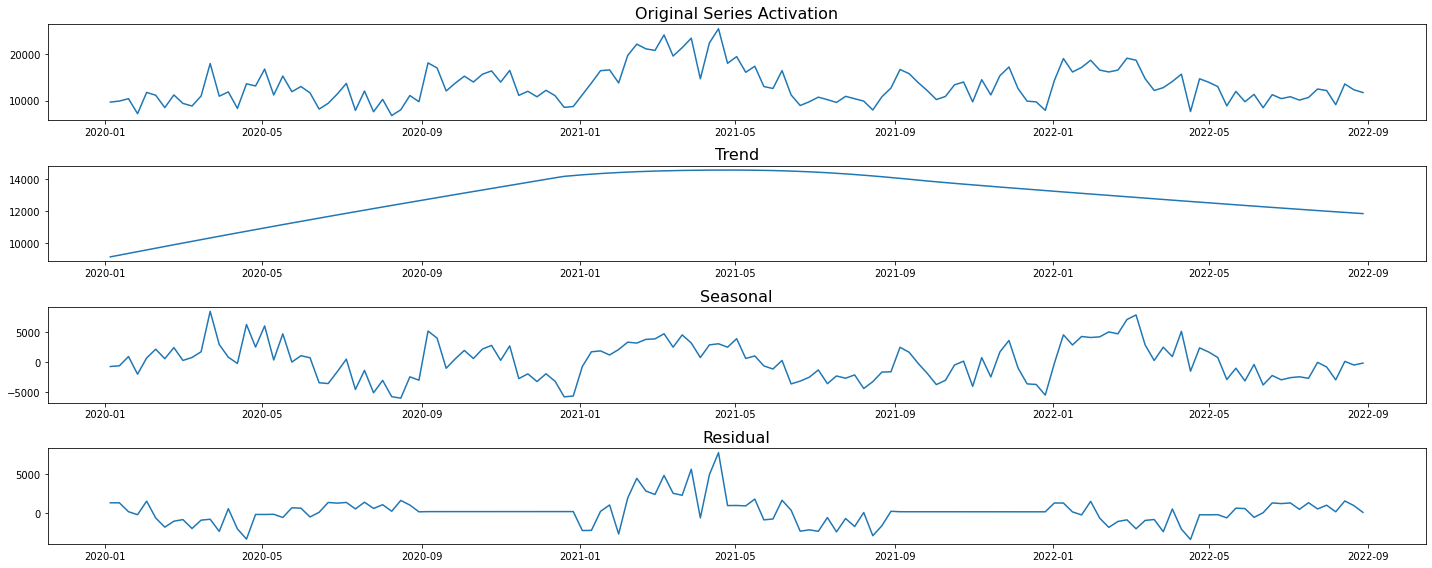

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

stl_conversions = STL(with_covid.set_index(['ds']))
result_conversions = stl_conversions.fit()

seasonal_conversions, trend_conversions, resid_conversions = result_conversions.seasonal, result_conversions.trend, result_conversions.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(with_covid.set_index(['ds']))
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_conversions)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_conversions)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_conversions)
plt.title('Residual', fontsize=16)

plt.tight_layout()

#Train and Test Split

In [0]:
train_df = with_covid.iloc[:int(len(with_covid)*0.8)]
train_df_index = train_df.set_index(['ds'])
test_df = with_covid.iloc[int(len(with_covid)*0.8):]
test_df_index = test_df.set_index(['ds'])

print('train:', len(train_df), ' test:', len(test_df), ' total:', len(with_covid))

## train_df >> 01.03 to 27.07
## train_df >> 28.07 to 30.09

train: 111 test: 28 total: 139

#Weekly

##Train

/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
 warnings.warn(

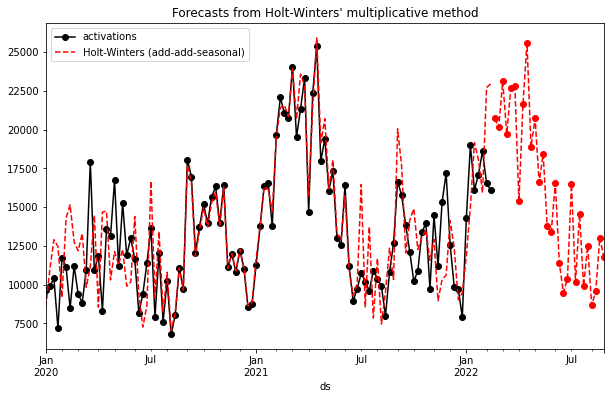

Out[66]:

,Additive Dam
alpha,2.878571e-01
beta,1.919048e-02
phi,9.900000e-01
gamma,1.186905e-01
l0,1.140097e+04
b0,1.555578e+02
SSE,6.814118e+08


In [0]:
fit3 = ExponentialSmoothing(
    train_df_index,
    seasonal_periods=52,
    trend='add',
    seasonal='mul',
    damped_trend=True,
    # initial_level = 0.9,
    # initial_trend = 0.9,
    # initial_seasonal= 0.9,
    initialization_method='estimated',
    freq = 'W',
).fit()


results = pd.DataFrame(
    index=['alpha', 'beta', 'phi', 'gamma', 'l0', 'b0', 'SSE']
)

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]

results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

ax = train_df_index.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)

fit3.fittedvalues.plot(ax=ax, style="--", color="red")

fit3.forecast(len(test_df)).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)

plt.show()
results

In [0]:
fit3_df = fit3.fittedvalues.to_frame()
fit3_df_columns = ['activations']
fit3_df.columns = fit3_df_columns
fit3_df.head()

Out[67]:

,activations
ds,
2020-01-05 00:00:00+00:00,8558.186992
2020-01-12 00:00:00+00:00,11001.544810
2020-01-19 00:00:00+00:00,12899.199230
2020-01-26 00:00:00+00:00,12455.957642
2020-02-02 00:00:00+00:00,9172.645751


In [0]:
##historical forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ' + str(r2_score(train_df_index, fit3_df)))
print('MAPE: ' + str(mean_absolute_percentage_error(train_df_index, fit3_df)))
print('RMSE', mean_squared_error(train_df_index, fit3_df, squared=False))

R-aquared: 0.624986287744864
MAPE: 0.14481791284473824
RMSE 2477.669280762918

##Test

In [0]:
forecast_test= fit3.forecast(len(test_df)).to_frame()
forecast_test = forecast_test.reset_index()
forecast_test.columns = ['ds', 'forecasted_activations']
forecast_test_index = forecast_test.set_index(['ds'])
forecast_test_index.tail()

Out[69]:

,forecasted_activations
ds,
2022-07-31 00:00:00+00:00,12509.195988
2022-08-07 00:00:00+00:00,8672.828430
2022-08-14 00:00:00+00:00,9555.852946
2022-08-21 00:00:00+00:00,13037.247549
2022-08-28 00:00:00+00:00,11790.406182


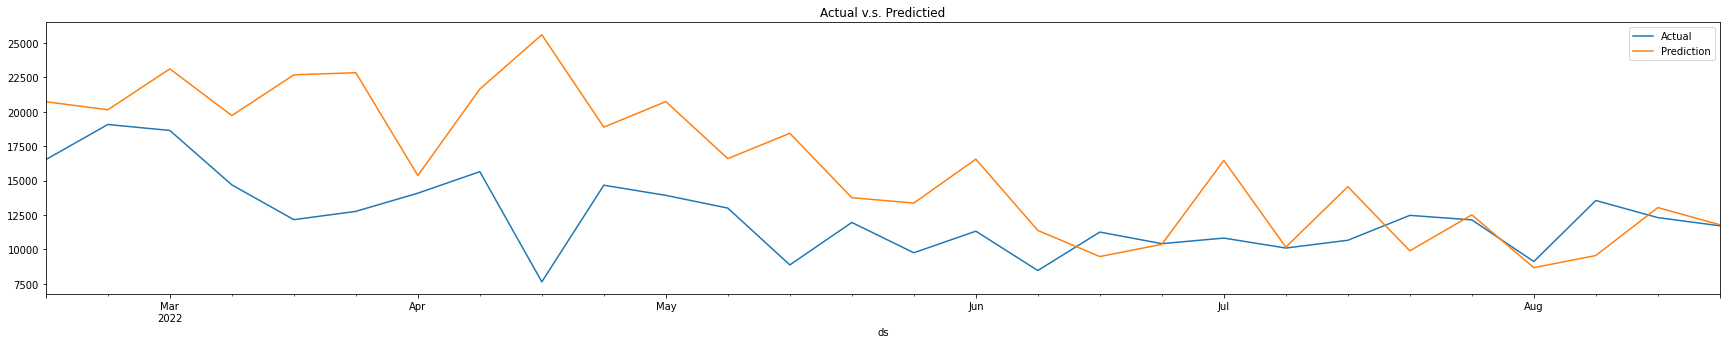

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

test_df.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
forecast_test.plot(kind='line',x='ds', y='forecasted_activations', label='Prediction', ax=ax)
plt.title('Actual v.s. Predictied')
plt.legend()
plt.show()

In [0]:
##test forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ', str(r2_score(test_df_index, forecast_test_index)))
print('MAPE: ' , str(mean_absolute_percentage_error(test_df_index, forecast_test_index)))
print('RMSE', mean_squared_error(test_df_index, forecast_test_index, squared=False))

R-aquared: -3.334517846607427
MAPE: 0.3760495563474665
RMSE 5764.423718083539

#Monthly

In [0]:
df_input = df[['ds', 'simulated']]
df_input = df_input.rename(columns = {'simulated' : 'activations'})
df_input['ds'] =  pd.to_datetime(df_input['ds'])
df_input_montly = df_input.set_index(['ds']).resample('M').sum()
df_input_montly.head()

Out[72]:

,activations
ds,
2018-01-31 00:00:00+00:00,21302.0
2018-02-28 00:00:00+00:00,21943.0
2018-03-31 00:00:00+00:00,18623.0
2018-04-30 00:00:00+00:00,23210.0
2018-05-31 00:00:00+00:00,24569.0


In [0]:
with_covid_month = df_input_montly[df_input_montly.index >= '2020-01-01']
with_covid_month.tail()

Out[73]:

,activations
ds,
2022-04-30 00:00:00+00:00,52037.0
2022-05-31 00:00:00+00:00,57511.0
2022-06-30 00:00:00+00:00,41465.0
2022-07-31 00:00:00+00:00,56200.0
2022-08-31 00:00:00+00:00,46695.0


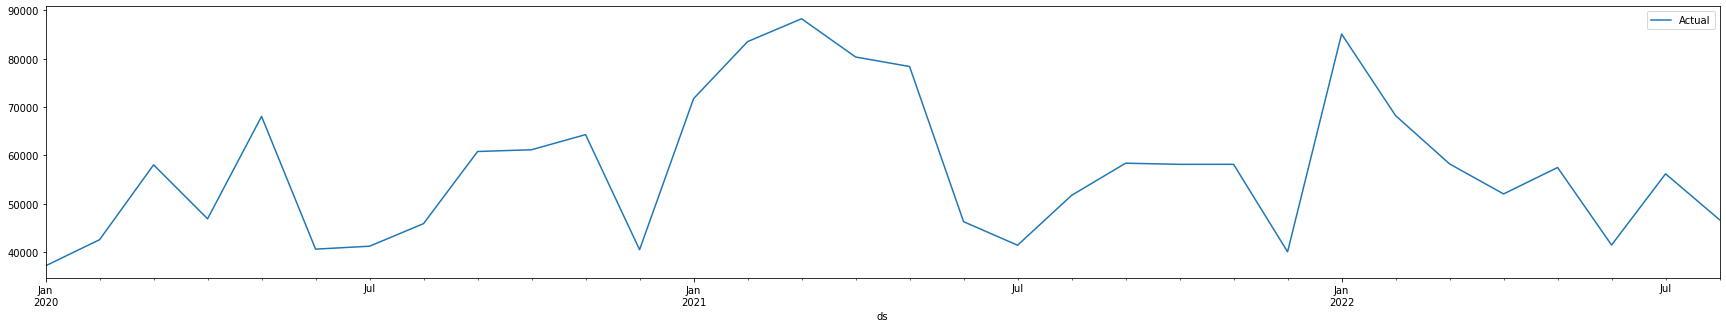

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

with_covid_month.plot(kind='line',y='activations', label='Actual', ax=ax)
plt.legend()
plt.show()

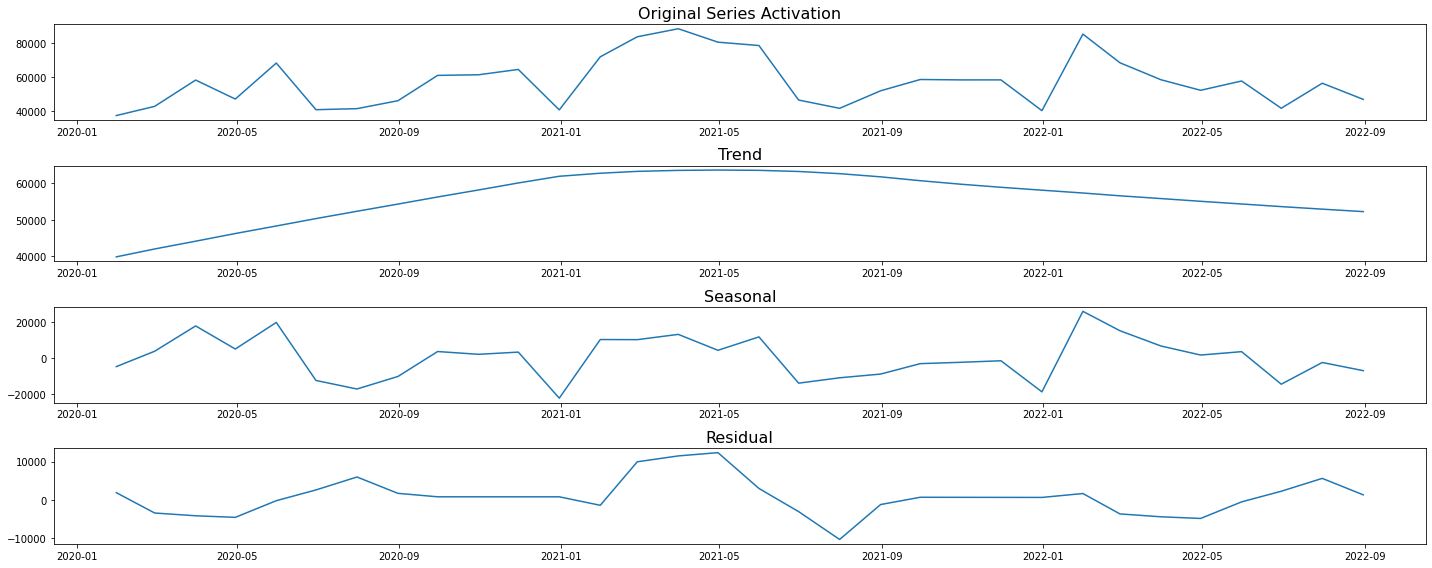

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

stl_conversions = STL(with_covid_month)
result_conversions = stl_conversions.fit()

seasonal_conversions, trend_conversions, resid_conversions = result_conversions.seasonal, result_conversions.trend, result_conversions.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(with_covid_month)
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_conversions)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_conversions)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_conversions)
plt.title('Residual', fontsize=16)

plt.tight_layout()

In [0]:
train_df_monthly = with_covid_month.iloc[:int(len(with_covid_month)*0.8)]
test_df_monthly = with_covid_month.iloc[int(len(with_covid_month)*0.8):]

print('train:', len(train_df_monthly), ' test:', len(test_df_monthly), ' total:', len(with_covid_month))

train: 25 test: 7 total: 32

In [0]:
test_df_monthly.head()

Out[77]:

,activations
ds,
2022-02-28 00:00:00+00:00,68245.0
2022-03-31 00:00:00+00:00,58252.0
2022-04-30 00:00:00+00:00,52037.0
2022-05-31 00:00:00+00:00,57511.0
2022-06-30 00:00:00+00:00,41465.0


##Train

/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
 warnings.warn(

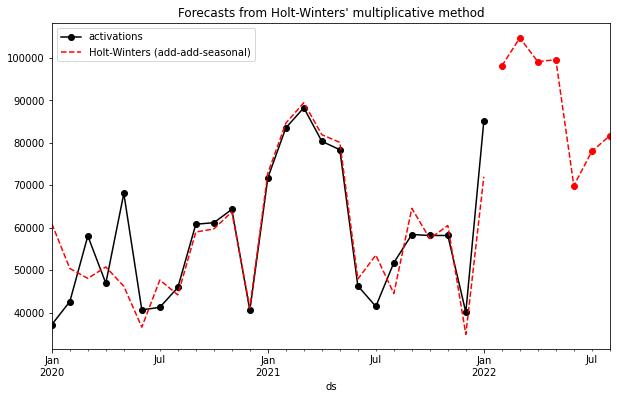

Out[96]:

,Additive Dam
alpha,9.596429e-01
beta,1.000000e-04
phi,9.900000e-01
gamma,1.000000e-04
l0,5.394350e+04
b0,1.032953e+00
SSE,1.743891e+09


In [0]:
fit3 = ExponentialSmoothing(
    train_df_monthly,
    seasonal_periods=12,
    trend="mul",
    seasonal="add",
    damped_trend=True,
    # initial_level = 3,
    # initial_trend = 7,
    # initial_seasonal= 5,
    initialization_method="estimated",
    freq = 'M',
).fit()


results = pd.DataFrame(
    index=['alpha', 'beta', 'phi', 'gamma', 'l0', 'b0', 'SSE']
)

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]

results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

ax = train_df_monthly.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)

fit3.fittedvalues.plot(ax=ax, style="--", color="red")

fit3.forecast(len(test_df_monthly)).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)

plt.show()
results

In [0]:
fit3_df = fit3.fittedvalues.to_frame()
fit3_df_columns = ['activations']
fit3_df.columns = fit3_df_columns
fit3_df.head()

Out[97]:

,activations
ds,
2020-01-31 00:00:00+00:00,60945.744148
2020-02-29 00:00:00+00:00,50389.931110
2020-03-31 00:00:00+00:00,48046.030681
2020-04-30 00:00:00+00:00,50748.974639
2020-05-31 00:00:00+00:00,46174.983711


In [0]:
##historical forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ' + str(r2_score(train_df_monthly, fit3_df)))
print('MAPE: ' + str(mean_absolute_percentage_error(train_df_monthly, fit3_df)))
print('RMSE', mean_squared_error(train_df_monthly, fit3_df, squared=False))

R-aquared: 0.7175812803548948
MAPE: 0.1107020835011678
RMSE 8351.984592356841

##Test

In [0]:
forecast_test= fit3.forecast(len(test_df_monthly)).to_frame()
forecast_test = forecast_test.reset_index()
forecast_test.columns = ['ds', 'forecasted_activations']
forecast_test_index = forecast_test.set_index(['ds'])
forecast_test_index.head()

Out[99]:

,forecasted_activations
ds,
2022-02-28 00:00:00+00:00,98153.469739
2022-03-31 00:00:00+00:00,104770.097196
2022-04-30 00:00:00+00:00,99136.331974
2022-05-31 00:00:00+00:00,99634.177938
2022-06-30 00:00:00+00:00,69917.613992


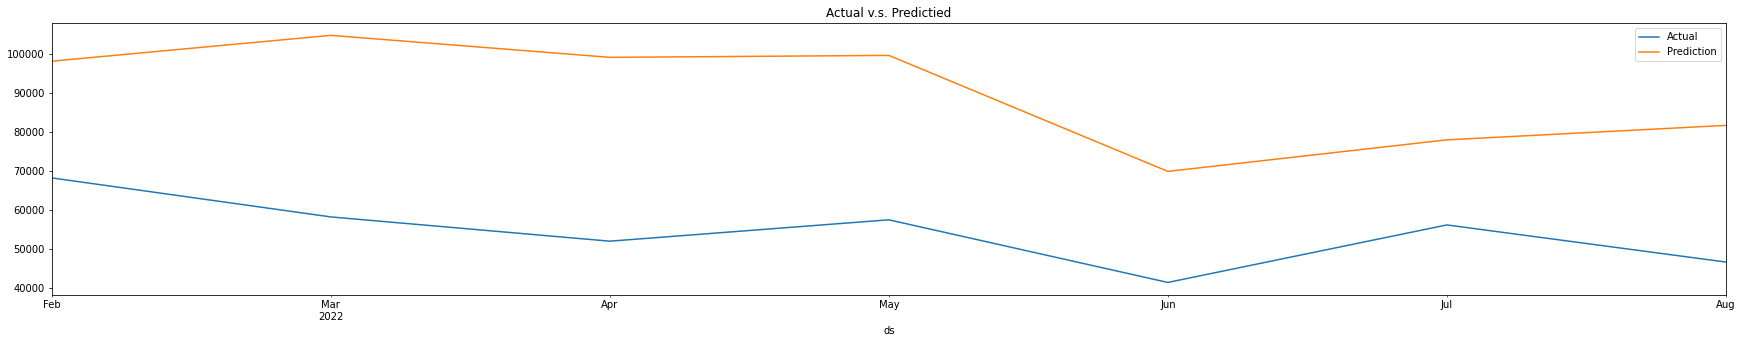

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

test_df_monthly.plot(kind='line',y='activations', label='Actual', ax=ax)
forecast_test_index.plot(kind='line',y='forecasted_activations', label='Prediction', ax=ax)
plt.title('Actual v.s. Predictied')
plt.legend()
plt.show()

In [0]:
##test forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ', str(r2_score(test_df_monthly, forecast_test_index)))
print('MAPE: ' , str(mean_absolute_percentage_error(test_df_monthly, forecast_test_index)))
print('RMSE', mean_squared_error(test_df_monthly, forecast_test_index, squared=False))

R-aquared: -20.16799400884854
MAPE: 0.6711526401424175
RMSE 36957.934791734806